In [1]:
import numpy as np
from sklearn import decomposition
import pulse2percept as p2p

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rc('axes', **{'grid': False})

2017-05-01 13:42:22,240 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
argus = p2p.implants.ArgusII()

In [3]:
sim = p2p.Simulation(argus)

In [4]:
sim.set_optic_fiber_layer(sampling=150, x_range=[-4000, 2500], y_range=[-3000, 3000])

In [5]:
all_ecs = None
for e in argus:
    cs = e.current_spread(sim.ofl.gridx, sim.ofl.gridy, 'OFL')
    ecs = sim.ofl.current2effectivecurrent(cs)
    if all_ecs is None:
        all_ecs = ecs
    else:
        all_ecs += ecs

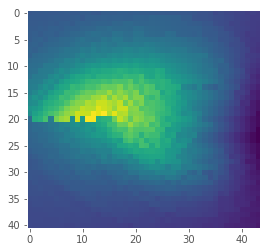

In [6]:
plt.imshow(all_ecs)

In [7]:
V = np.zeros((all_ecs.size, argus.num_electrodes))

In [8]:
for i, e in enumerate(argus):
    cs = e.current_spread(sim.ofl.gridx, sim.ofl.gridy, 'OFL')
    ecs = sim.ofl.current2effectivecurrent(cs)
    V[:, i] = ecs.ravel()

In [9]:
pca = decomposition.PCA()
V_new = pca.fit_transform(V)

In [10]:
n90 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0]
n90

6

In [11]:
n95 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]
n95

9

In [12]:
n99 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]
n99

21

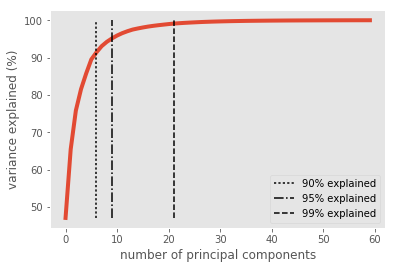

In [13]:
var_perc = np.cumsum(pca.explained_variance_ratio_ * 100)
plt.plot(var_perc, linewidth=4)
plt.ylabel('variance explained (%)')
plt.xlabel('number of principal components')
plt.plot([n90, n90], [var_perc[0], 100], 'k:', label='90% explained')
plt.plot([n95, n95], [var_perc[0], 100], 'k-.', label='95% explained')
plt.plot([n99, n99], [var_perc[0], 100], 'k--', label='99% explained')
plt.legend(loc='lower right')

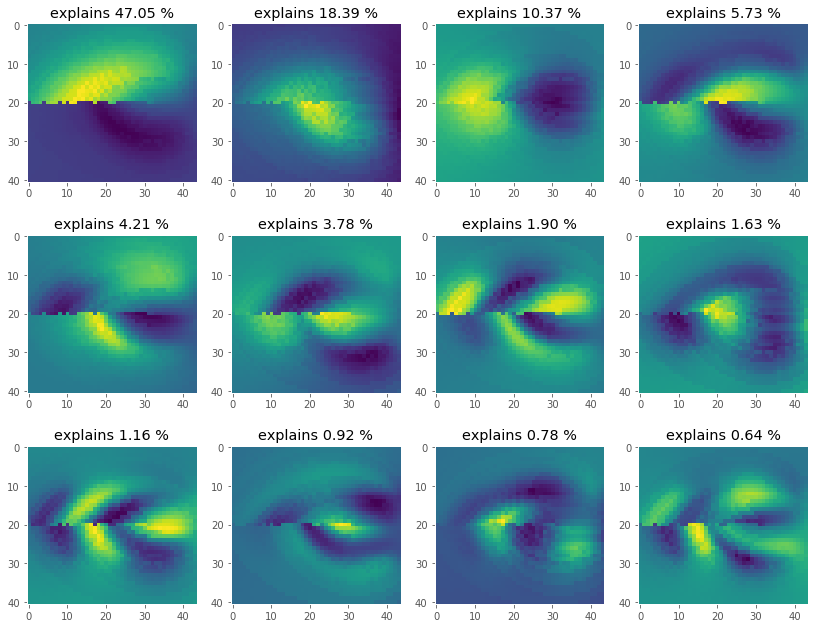

In [14]:
plt.figure(figsize=(14, 11))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(V_new[:, i].reshape(ecs.shape))
    plt.grid('off')
    title = 'explains %.2f %%' % (pca.explained_variance_ratio_[i] * 100)
    plt.title(title)

In [15]:
class InterpSim(p2p.Simulation):
    def __init__(self, implant, name=None, engine='joblib', dojit=True, num_jobs=-1):
        if not isinstance(implant, p2p.implants.ElectrodeArray):
            e_s = "`implant` must be of type p2p.implants.ElectrodeArray"
            raise TypeError(e_s)

        self.name = name
        self.implant = implant
        self.engine = engine
        self.dojit = dojit
        self.num_jobs = num_jobs

        # Optic fiber layer (OFL): After calling `set_optic_fiber_layer`, this
        # variable will contain a `p2p.retina.Grid` object.
        self.ofl = None

        # Ganglion cell layer (GCL): After calling `set_ganglion_cell_layer`,
        # this variable will contain a `p2p.retina.TemporalModel` object.
        self.gcl = None
        
    def set_ganglion_cell_layer(self, loadfile):
        from scipy.interpolate import RegularGridInterpolator
        import pickle
        
        in_list, out_list = pickle.load(open(loadfile, 'rb'))
        in_arr = np.array(in_list)
        amps = np.unique(in_arr[:, 0])
        freqs = np.unique(in_arr[:, 1])
        ecs = np.unique(in_arr[:, 2])
        out_arr = np.array(out_list).reshape((len(amps), len(freqs), len(ecs)))

        self.gcl = RegularGridInterpolator((amps, freqs, ecs), out_arr,
                                           bounds_error=False, fill_value=None)
        
    def p2p(self, amps, freq, layers=['OFL', 'GCL']):
        if 'OFL' in layers:
            ecs, _ = self.ofl.electrode_ecs(self.implant)
        else:
            _, ecs = self.ofl.electrode_ecs(self.implant)
            
        # Sum up current contributions from all electrodes
        ecs = np.sum(ecs[:, :, 1, :] * amps.flatten(), axis=-1)
        
        out_list = np.array([self.gcl([a, freq, 1]) for a in ecs.flatten()])
        out_list[ecs.flatten() < 0] = 0.0
        return out_list.reshape(ecs.shape)

In [16]:
sim = InterpSim(argus)
sim.set_optic_fiber_layer(sampling=150)
sim.set_ganglion_cell_layer('temporal-model-amps-freqs-ecs.dat')

In [17]:
VV = []
for i, e in enumerate(argus):
    for a in np.linspace(0, 50, 6):
        amps = np.zeros(argus.num_electrodes)
        amps[i] = a
        percept = sim.p2p(amps, 20, layers=['GCL', 'OFL'])
        VV.append(percept.ravel())
VV = np.array(VV).T

In [18]:
pca = decomposition.PCA()
VV_new = pca.fit_transform(VV)

In [19]:
n90 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.9)[0][0]
n90

8

In [20]:
n95 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.95)[0][0]
n95

14

In [21]:
n99 = np.where(np.cumsum(pca.explained_variance_ratio_) > 0.99)[0][0]
n99

41

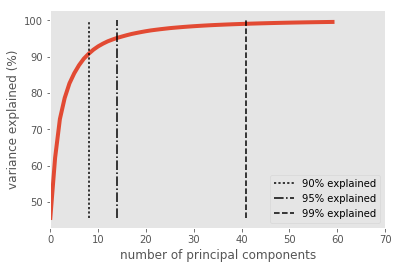

In [22]:
var_perc = np.cumsum(pca.explained_variance_ratio_[:60] * 100)
plt.plot(var_perc, linewidth=4)
plt.ylabel('variance explained (%)')
plt.xlabel('number of principal components')
plt.plot([n90, n90], [var_perc[0], 100], 'k:', label='90% explained')
plt.plot([n95, n95], [var_perc[0], 100], 'k-.', label='95% explained')
plt.plot([n99, n99], [var_perc[0], 100], 'k--', label='99% explained')
plt.xlim(0, 70)
plt.legend(loc='lower right')

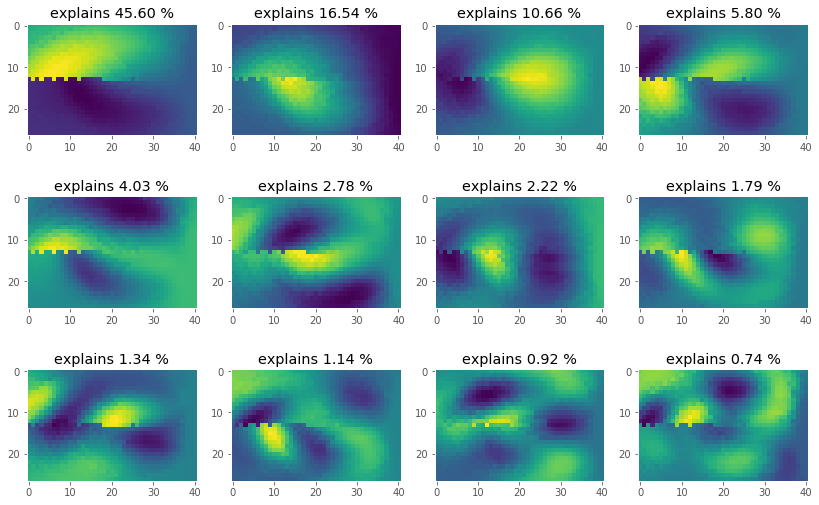

In [23]:
plt.figure(figsize=(14, 9))
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.imshow(VV_new[:, i].reshape(sim.ofl.gridx.shape))
    plt.grid('off')
    title = 'explains %.2f %%' % (pca.explained_variance_ratio_[i] * 100)
    plt.title(title)